# PMC - Gaussian shells example

Importing libraries and setting the random seed for reproducibility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pocomc as pc

np.random.seed(0)

## Defining the likelihood and prior

The likelihood is given by $\mathcal{L}(x) = 0.5 \mathcal{L}_1(x) + 0.5 \mathcal{L}_2(x)$ where the log likelihood of a single shell with center $c_i$ is
$$
\log \mathcal{L}_i(x) = -0.5\log \left(2\pi w^2\right) - \frac{1}{2w^2} \left(||x-c_i||_2 - r\right)^2.
$$
Our prior is given by $\pi(x) = U(-6, 6)$ for both dimensions.

We use PMC to obtain samples $x_i \sim \mathcal{P}(x) \propto \mathcal{L}(x)\pi(x)$.

In [2]:
###############################
### Defining the likelihood ###
###############################

r = 2.0  # Shell radius
w = 0.1  # Shell width
c1 = np.array([-3.5, 0.])  # Center of shell 1
c2 = np.array([3.5, 0.])   # Center of shell 2
norm_const = math.log(1. / math.sqrt(2. * math.pi * w ** 2))  # normalization constant

# log-likelihood of a single shell
def logcirc(theta, c):
    d = np.sqrt(np.sum((theta - c)**2, axis=-1))  # |theta - c|
    return norm_const - (d - r)**2 / (2. * w**2)

# log-likelihood of two shells
def log_likelihood(x):
    return np.logaddexp(logcirc(x, c1), logcirc(x, c2))

###############################
##### Defining the prior ######
###############################

lower = np.array([-6.0, -6.0]) # lower bound of the prior
upper = np.array([6.0, 6.0])   # upper bound of the prior
bounds = np.c_[lower, upper]
const = np.sum(np.log(upper - lower))  # log of the Uniform density

def log_prior(x):
    if np.any((x < lower) | (x > upper)):  # If any dimension is out of bounds, the log prior is -infinity
        return -np.inf 
    else:
        return -const

## Running PMC

We run PMC with 1000 walkers, initialized to be prior samples.

In [3]:
nwalkers = 1000
prior_samples = np.random.uniform(size=(nwalkers, 2), low=-6.0, high=6.0)

pmc = pc.Sampler(
    nwalkers,
    2,
    log_likelihood,
    log_prior,
    bounds=bounds,
    train_config={'l1': 0.2},
    random_state=0
)
pmc.run(prior_samples)

Iter: 17it [01:13,  4.32s/it, beta=1, calls=7e+4, ESS=0.979, logZ=-2.38, accept=0.143, N=17, scale=0.338, corr=0.743]    


## Visualizing the PMC posterior

We visualize the final PMC samples. The samples accurately represent the posterior.

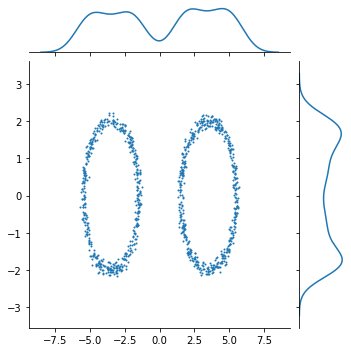

In [4]:
import seaborn as sns

x = pmc.results['samples']
g = sns.JointGrid(height=5)
g.ax_joint.scatter(x[:, 0], x[:, 1], s=1.0)
sns.kdeplot(x=x[:, 0], ax=g.ax_marg_x)
sns.kdeplot(y=x[:, 1], ax=g.ax_marg_y)
plt.show()

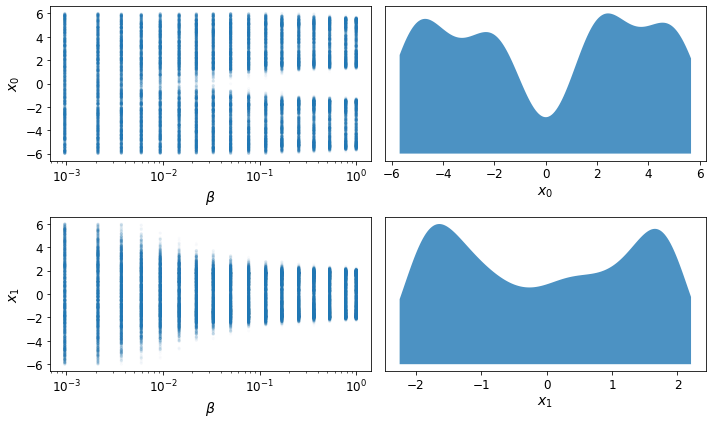

In [5]:
pc.plotting.trace(pmc.results)
plt.show()

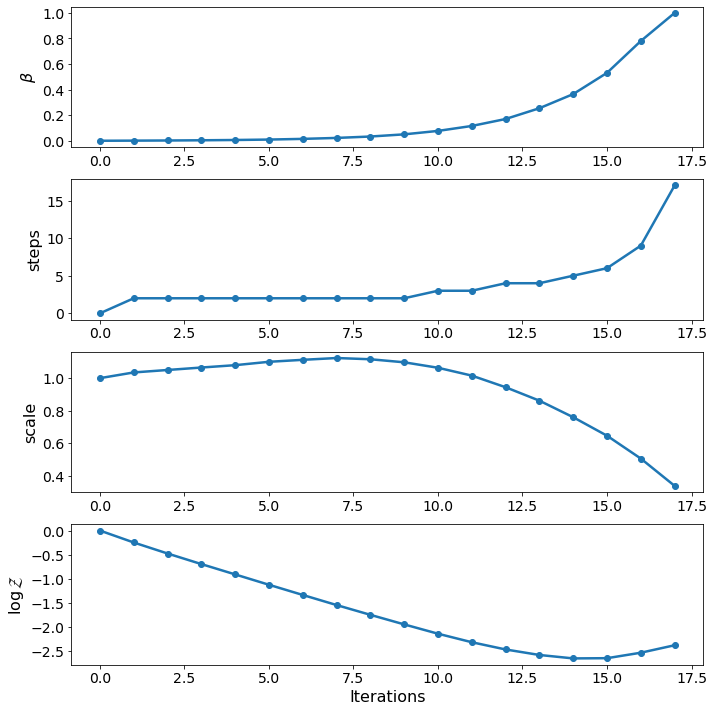

In [6]:
pc.plotting.run(pmc.results)
plt.show()